# Lab 04 assignment notebook 2 (20 pts)
*Notebook 2 of 2*

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Part 0: Setup from  Notebook #1

In [1]:
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path
import os
import numpy as np
import xarray as xr

In [2]:
#May want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

In [3]:
imgdir = f'{Path.home()}/gda_demo_data/LS8_data'

In [4]:
!ls -lh $imgdir

total 1.3G
-rw-r--r-- 1 eric eric 1.2M Jan 26 11:31 LC08_L2SP_046027_20180818_02_T1_rendered_preview.png
-rw-r--r-- 1 eric eric  81M Jan 26 11:27 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B1.TIF
-rw-r--r-- 1 eric eric  81M Jan 26 11:28 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B2.TIF
-rw-r--r-- 1 eric eric  82M Jan 26 11:28 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B3.TIF
-rw-r--r-- 1 eric eric  83M Jan 26 11:29 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B4.TIF
-rw-r--r-- 1 eric eric  92M Jan 26 11:29 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B5.TIF
-rw-r--r-- 1 eric eric  90M Jan 26 11:30 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B6.TIF
-rw-r--r-- 1 eric eric  84M Jan 26 11:31 LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF
-rw-r--r-- 1 eric eric 115M Jan 27 19:39 LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10_4326.TIF
-rw-r--r-- 1 eric eric 1.5M Jan 26 11:27 LC08_L2SP_046027_20181224_02_T1_rendered_preview.png
-rw-r--r-- 1 eric eric  91M Jan 26 11:23 LC08_L2SP_046027_

In [5]:
#Pre-identified cloud-free Image IDs used for the lab
august_id = 'LC08_L2SP_046027_20180818_20200831_02_T1' # August 2018
december_id = 'LC08_L2SP_046027_20181224_20200829_02_T1' # # December 2018

In [6]:
# B10 is the thermal infrared /surface temperture band
tir_august_fn = os.path.join(imgdir, august_id+'_ST_B10.TIF')
tir_december_fn = os.path.join(imgdir, december_id+'_ST_B10.TIF')

swir_august_fn = os.path.join(imgdir, august_id+'_SR_B6.TIF')
swir_december_fn = os.path.join(imgdir, december_id+'_SR_B6.TIF')

nir_august_fn = os.path.join(imgdir, august_id+'_SR_B5.TIF')
nir_december_fn = os.path.join(imgdir, december_id+'_SR_B5.TIF')

red_august_fn = os.path.join(imgdir, august_id+'_SR_B4.TIF')
red_december_fn = os.path.join(imgdir, december_id+'_SR_B4.TIF')

green_august_fn = os.path.join(imgdir, august_id+'_SR_B3.TIF')
green_december_fn = os.path.join(imgdir, december_id+'_SR_B3.TIF')

blue_august_fn = os.path.join(imgdir, august_id+'_SR_B2.TIF')
blue_december_fn = os.path.join(imgdir, december_id+'_SR_B2.TIF')

### We've had practice opening Landsat-8 data using rioxarray, squeezing, selecting a window, masking, and scaling to a geophysical variable! Since we're going to repeat this process many more times for the remainder of this lab, let's build a quick function that accepts a filename amd returns a raster of the given geophysical variable over Mt. Rainier as a masked Xarray DataArray

In [7]:
#Scale and offset values for L2 Landsat products
#Surface Reflectance 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2

st_scale = 0.00341802
st_offset = 149.0

rainier_x_slice = slice(581685.0, 612405.0)
rainier_y_slice = slice(5205615.0, 5174895.0)

def rxr_read_crop_mask_scale_ls8(fn):
    """Pass in a filename, read the raster file with rioxarray, mask nodata values, and scale to either surface reflectance or surface temperature"""
    da = rxr.open_rasterio(fn,masked=True).squeeze().sel(x=rainier_x_slice, y=rainier_y_slice)

    if fn.endswith('ST_B10.TIF'):
        da = da * st_scale + st_offset
        da = da - 273.15
    else:
        da = da * sr_scale + sr_offset

    return da

## Part 6: Composite images (3 pts)

First, please take a look at this quick [explainer on composite imagery](http://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html).

The many bands of Landsat-8 allow for diverse composite images with different use cases. 

### Let's take a look at all of the bands we downloaded for the August 2018 acqusition

In [8]:
all_august_bands = [blue_august_fn, green_august_fn, red_august_fn, nir_august_fn, swir_august_fn, tir_august_fn]


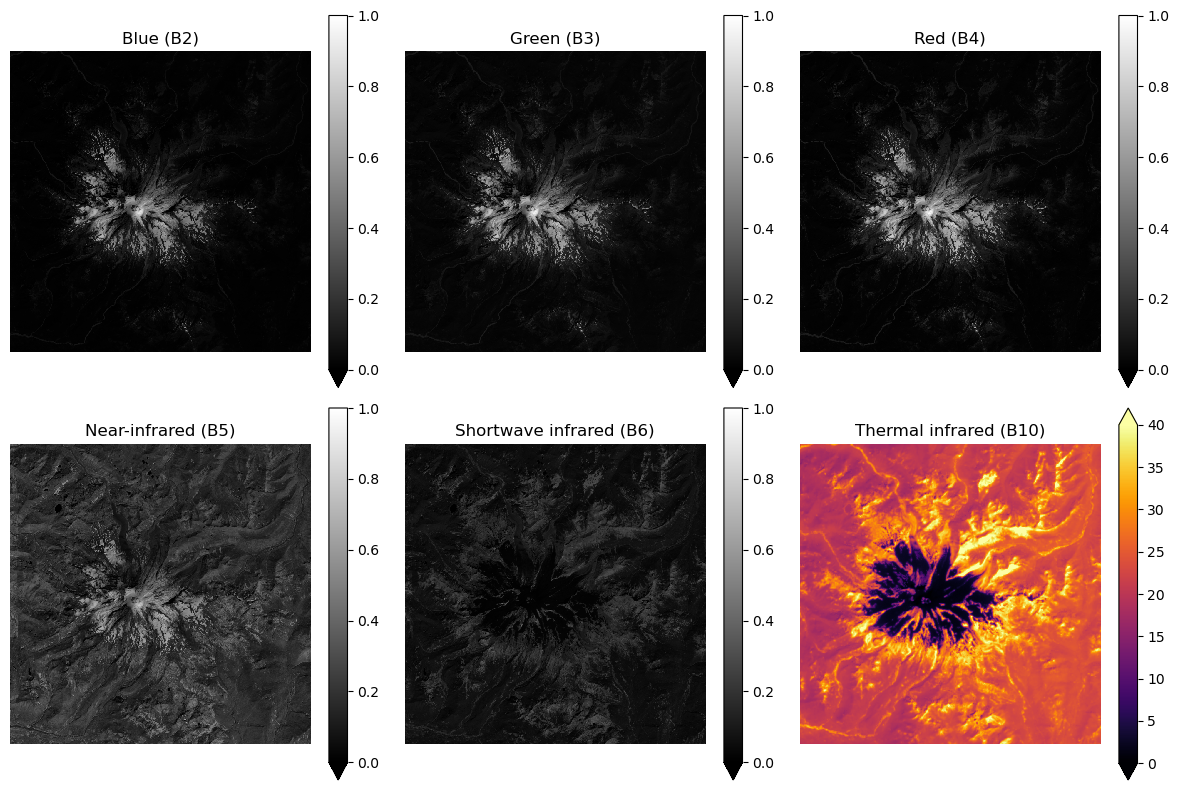

In [9]:
f,axs=plt.subplots(2,3,figsize=(12,8))

band_names = ['Blue', 'Green', 'Red', 'Near-infrared', 'Shortwave infrared', 'Thermal infrared']
for band,ax in zip(all_august_bands, axs.flat):

    da = rxr_read_crop_mask_scale_ls8(band)

    if 'ST' in band:
        da.plot.imshow(ax=ax,cmap='inferno',vmin=0,vmax=40)
    else:
        da.plot.imshow(ax=ax,cmap='gray',vmin=0,vmax=1)


    ax.set_title(f"{band_names.pop(0)} ({band.split('_')[-1].split('.')[0]})")

    ax.axis('off')

    ax.set_aspect('equal')

f.tight_layout()


### Let's plot some composite images!
* First, figure out what bands you'll need and read them in using the helper function we just defined `rxr_read_crop_mask_scale_ls8(fn)`
    * For example `red_august_da = rxr_read_crop_mask_scale_ls8(red_august_fn)`
* Use xarray's concat function to merge the xarray DataArrays along a new band dimension
    * Check out the rioxarray tutorial for a refresher on this

#### *Create a figure with 4 plots: red, green, blue, and the "true" / "natural" RGB composite image*
* Try using colormaps that correspond to the band (e.g. 'Reds' for the red band)
* Set `vmin=0` and `vmax=1` for the single band plots

In [10]:
red_august_da = rxr_read_crop_mask_scale_ls8(red_august_fn)
green_august_da = rxr_read_crop_mask_scale_ls8(green_august_fn)
blue_august_da = rxr_read_crop_mask_scale_ls8(blue_august_fn)

In [11]:
# STUDENT CODE HERE

<xarray.DataArray (band: 3, y: 1024, x: 1024)> Size: 13MB
array([[[0.020495  , 0.021705  , 0.0201925 , ..., 0.01466499,
         0.01210749, 0.00966001],
        [0.0198625 , 0.01933999, 0.01744249, ..., 0.0189275 ,
         0.0096875 , 0.00933   ],
        [0.01681   , 0.01593   , 0.0150225 , ..., 0.01727749,
         0.0115025 , 0.01142   ],
        ...,
        [0.012135  , 0.01031999, 0.0114475 , ..., 0.01263   ,
         0.012575  , 0.01309749],
        [0.011585  , 0.01199751, 0.01252   , ..., 0.0112    ,
         0.01293249, 0.01265749],
        [0.012245  , 0.01232749, 0.0112275 , ..., 0.01504999,
         0.0146925 , 0.0137575 ]],

       [[0.037435  , 0.03922249, 0.0376275 , ..., 0.02602249,
         0.02329999, 0.0221725 ],
        [0.03515249, 0.03427249, 0.0319075 , ..., 0.02731501,
         0.0232725 , 0.024675  ],
        [0.031385  , 0.0281675 , 0.02769999, ..., 0.0280575 ,
         0.0268475 , 0.02791999],
...
        [0.02539   , 0.022695  , 0.0248675 , ..., 0.0283875 ,
         0.0282225 , 0.02959751],
        [0.0244    , 0.02539   , 0.02802999, ..., 0.02627   ,
         0.02858   , 0.02775499],
        [0.02412499, 0.02607749, 0.02462   , ..., 0.030285  ,
         0.03058749, 0.0299    ]],

       [[0.01851501, 0.0185975 , 0.016425  , ..., 0.01285   ,
         0.01131   , 0.01031999],
        [0.0182125 , 0.0160675 , 0.01477499, ..., 0.01628751,
         0.008395  , 0.0095225 ],
        [0.015985  , 0.01351   , 0.01254749, ..., 0.01532499,
         0.00971501, 0.0107325 ],
        ...,
        [0.00801   , 0.00713   , 0.007515  , ..., 0.00922   ,
         0.0092475 , 0.009385  ],
        [0.00746   , 0.00831249, 0.008505  , ..., 0.008725  ,
         0.009385  , 0.0095775 ],
        [0.00842249, 0.00834   , 0.007625  , ..., 0.01064999,
         0.01070499, 0.01070499]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 1 1
  * x            (x) float64 8kB 5.817e+05 5.817e+05 ... 6.124e+05 6.124e+05
  * y            (y) float64 8kB 5.206e+06 5.206e+06 ... 5.175e+06 5.175e+06
    spatial_ref  int64 8B 0

In [12]:
# STUDENT CODE HERE

<img src="imgs/rgb_august.png" width="1000">

### These plots are pretty faint 

Even though the surface reflectance values go from 0 to 1, most of the values are close to 0. Check out the following histograms...


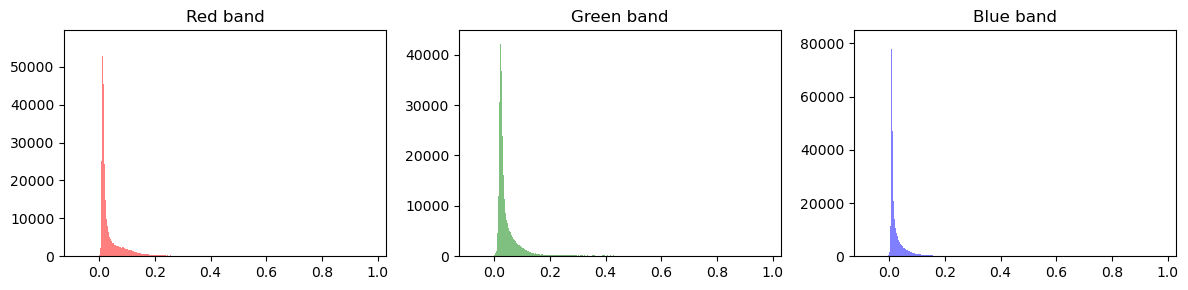

In [13]:
f,axs = plt.subplots(1,3,figsize=(12,3),sharex=True)

red_august_da.plot.hist(ax=axs[0],bins=1000,color='r',alpha=0.5);
green_august_da.plot.hist(ax=axs[1],bins=1000,color='g',alpha=0.5);
blue_august_da.plot.hist(ax=axs[2],bins=1000,color='b',alpha=0.5);

axs[0].set_title('Red band')
axs[1].set_title('Green band')
axs[2].set_title('Blue band')

f.tight_layout()

### We can address this a couple of ways: we can either change the actual array values, or change how we plot!

#### *Recreate the figure of the 3 seperate bands and the RGB composite. This time, use the provided function to create a normalized version of each DataArray, mapping the 2nd percentile of values to 0 and the 98th percentile to 1. For the RGB composite, you'll need to use `xr.concat` on the newly normalized rasters. Keep `vmin=0` and `vmax=1`*

In [14]:
def percentile_stretch(da, pmin=2, pmax=98):

    min_val = da.quantile(pmin/100)
    max_val = da.quantile(pmax/100)

    stretched = da.clip(min_val,max_val)
    stretched = (stretched - min_val) / (max_val - min_val)
    
    return stretched

In [15]:
# STUDENT CODE HERE

In [16]:
# STUDENT CODE HERE

<img src="imgs/rgb_august_normalized.png" width="1000">

In [17]:
red_august_norm_da = None
green_august_norm_da = None
blue_august_norm_da = None
rgb_august_norm_da = None

#### *Now we'll try it the other way. Recreate the figure of the 3 seperate bands and the RGB composite. This time, for each band, adjust each vmin and vmax such that they represent the 2nd and 98th percentile of the band values. Also, in the rgb image plot call, set `robust=True`*
Don't use the normalized DataArrays we just made!

Read about the robust option [here](https://docs.xarray.dev/en/latest/user-guide/plotting.html#robust)


In [18]:
red_percentile_2 = red_august_da.quantile(0.02)
red_percentile_98 = red_august_da.quantile(0.98)

green_percentile_2 = green_august_da.quantile(0.02)
green_percentile_98 = green_august_da.quantile(0.98)

blue_percentile_2 = blue_august_da.quantile(0.02)
blue_percentile_98 = blue_august_da.quantile(0.98)

In [19]:
# STUDENT CODE HERE

<img src="imgs/rgb_august_clim.png" width="1000">

#### *Written response: What makes these two approaches to contrast enhancement different? Why might we prefer one over the other?*

**STUDENT WRITTEN RESPONSE HERE**

### Let's get back to composite images

#### *Make a similar figure for color-infrared as described in the explainer above. Use `robust=True` on all plots in the figure*

In [20]:
# STUDENT CODE HERE

In [21]:
# STUDENT CODE HERE

<xarray.DataArray (band: 3, y: 1024, x: 1024)> Size: 13MB
array([[[0.46368504, 0.4773525 , 0.44704753, ..., 0.11834   ,
         0.08800749, 0.09017999],
        [0.4457    , 0.4263125 , 0.3925975 , ..., 0.06653   ,
         0.12034748, 0.157115  ],
        [0.38674003, 0.36611503, 0.3560775 , ..., 0.08327751,
         0.1772175 , 0.19388251],
        ...,
        [0.235215  , 0.21401249, 0.22520499, ..., 0.229385  ,
         0.2224    , 0.2434925 ],
        [0.22704749, 0.2374975 , 0.25086248, ..., 0.2078525 ,
         0.2253425 , 0.229825  ],
        [0.23920251, 0.23975249, 0.22803749, ..., 0.2269925 ,
         0.24143   , 0.2401375 ]],

       [[0.020495  , 0.021705  , 0.0201925 , ..., 0.01466499,
         0.01210749, 0.00966001],
        [0.0198625 , 0.01933999, 0.01744249, ..., 0.0189275 ,
         0.0096875 , 0.00933   ],
        [0.01681   , 0.01593   , 0.0150225 , ..., 0.01727749,
         0.0115025 , 0.01142   ],
...
        [0.012135  , 0.01031999, 0.0114475 , ..., 0.01263   ,
         0.012575  , 0.01309749],
        [0.011585  , 0.01199751, 0.01252   , ..., 0.0112    ,
         0.01293249, 0.01265749],
        [0.012245  , 0.01232749, 0.0112275 , ..., 0.01504999,
         0.0146925 , 0.0137575 ]],

       [[0.037435  , 0.03922249, 0.0376275 , ..., 0.02602249,
         0.02329999, 0.0221725 ],
        [0.03515249, 0.03427249, 0.0319075 , ..., 0.02731501,
         0.0232725 , 0.024675  ],
        [0.031385  , 0.0281675 , 0.02769999, ..., 0.0280575 ,
         0.0268475 , 0.02791999],
        ...,
        [0.02539   , 0.022695  , 0.0248675 , ..., 0.0283875 ,
         0.0282225 , 0.02959751],
        [0.0244    , 0.02539   , 0.02802999, ..., 0.02627   ,
         0.02858   , 0.02775499],
        [0.02412499, 0.02607749, 0.02462   , ..., 0.030285  ,
         0.03058749, 0.0299    ]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 1 1
  * x            (x) float64 8kB 5.817e+05 5.817e+05 ... 6.124e+05 6.124e+05
  * y            (y) float64 8kB 5.206e+06 5.206e+06 ... 5.175e+06 5.175e+06
    spatial_ref  int64 8B 0

In [22]:
# STUDENT CODE HERE

<img src="imgs/cir_august.png" width="1000">

#### *Written response: How might this CIR composite plot be useful?*

**STUDENT WRITTEN RESPONSE HERE**

## Part 7: Raster band math and index ratios (3 pts)

Let's use some common band ratios to classify vegetation, snow, and water

#### *Calculate NDVI (normalized difference vegetation index), clip values to [-1,1], and plot with `robust=True`*
Hint: Use the built-in DataArray method `.clip` for this!

[NDVI information](https://eos.com/ndvi/) 

[NDVI using Landsat-8 bands](https://custom-scripts.sentinel-hub.com/custom-scripts/landsat-8/ndvi/)


In [23]:
# STUDENT CODE HERE

In [24]:
# STUDENT CODE HERE

<img src="imgs/ndvi_august.png" width="1000">

#### *Written response: What differences do you see in NDVI values for dense conifer trees (most of the scene) vs. open meadows or recently logged plots dominated by grass and other deciduous plants?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Calculate NDSI (normalized difference snow index), clip values to [-1,1], and plot with `robust=True`*

[NDSI information](https://eos.com/ndsi/) 

[NDSI using Landsat-8 bands](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index)

In [25]:
# STUDENT CODE HERE

In [26]:
# STUDENT CODE HERE

<img src="imgs/ndsi_august.png" width="1000">

#### *Calculate NDWI (normalized difference water index), clip values to [-1,1], and plot with `robust=True`*

[NDWI information](https://eos.com/make-an-analysis/ndwi/) 

[NDWI using Landsat-8 bands](https://custom-scripts.sentinel-hub.com/custom-scripts/landsat-8/ndwi/)



In [27]:
# STUDENT CODE HERE

In [28]:
# STUDENT CODE HERE

<img src="imgs/ndwi_august.png" width="1000">

#### *Create a figure with linked RGB, CIR, surface temperature, NDVI, NDSI, and NDWI products*
* Add a scalebar on the RGB plot!
* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
    * Zoom in on some vegetation, snow near the summit, and surface water like [Mowich Lake](https://goo.gl/maps/V6YFJQPcfrDi9UXH6)
    * When you turn in the lab, make sure the plot is saved as a static plot and not the interactive version
* Note how the different indices change (see interactive values for cursor position on each subplot), which should hopefully provide better sense of what the different indices are showing

In [29]:
# STUDENT CODE HERE

<img src="imgs/multiplot_august.png" width="1000">

#### *Written response: Pan and zoom around interactively. Write about one thing or feature that you found interesting, making sure to incorporate information from at least three of the rasters.*

**STUDENT WRITTEN RESPONSE HERE**

## Part 8: Raster thresholding (2 pts)

### Create a binary vegetation mask
* We need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDVI values above this threshold will be classified as "vegetation"
    * NDVI values below this threshold will be classified as "not vegetation"

#### *To decide on a threshold, create a figure with an NDVI plot on the left and a histogram of NDVI values on the right*

In [30]:
# STUDENT CODE HERE

<img src="imgs/ndvi_august_hist.png" width="1000">

#### *Based on the histogram, choose an NDVI threshold and create a binary vegetation mask. Then create a figure with three subplots: CIR, NDVI, and your new veegtation mask.*

In [31]:
# STUDENT CODE HERE

<xarray.DataArray (y: 1024, x: 1024)> Size: 1MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 8kB 5.817e+05 5.817e+05 ... 6.124e+05 6.124e+05
  * y            (y) float64 8kB 5.206e+06 5.206e+06 ... 5.175e+06 5.175e+06
    spatial_ref  int64 8B 0

In [32]:
# STUDENT CODE HERE

<img src="imgs/veg_mask_august.png" width="1000">

#### *Create a binary snow mask. Then, create a figure with natural RGB, NDSI, and your new binary snow mask*
* Follow a similar procedure with thresholding to create a snow mask from NDSI

In [33]:
# STUDENT CODE HERE

<img src="imgs/ndsi_august_hist.png" width="1000">

In [34]:
# STUDENT CODE HERE

In [35]:
# STUDENT CODE HERE

<img src="imgs/snow_mask_august.png" width="1000">

## Part 9: Raster area and change (3 pts)

### Use your snow mask to estimate the area (km<sup>2</sup>) covered by snow in August and in December

#### *Bring in the December rasters, creating a natural RGB composite an NDSI image, and a binary snow mask*
Use the same NDSI threshold for both August and December!

In [36]:
# STUDENT CODE HERE

In [37]:
# STUDENT CODE HERE

<xarray.DataArray (y: 1024, x: 1024)> Size: 4MB
array([[-0.12144855, -0.22127382, -0.13928398, ...,  1.        ,
         1.        ,  1.        ],
       [-0.14421098, -0.14118597, -0.03769719, ...,  1.        ,
         1.        , -1.        ],
       [-0.00795951,  0.02210915,  0.01732341, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.13700016, -0.14488819, -0.13657251, ...,  0.21691905,
         0.2368435 ,  0.38473162],
       [-0.15323447, -0.15313424, -0.15563335, ...,  0.11950976,
         0.19356021,  0.2021742 ],
       [-0.15105893, -0.15632582, -0.1772668 , ...,  0.11733061,
         0.15551701,  0.2443123 ]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 8kB 5.817e+05 5.817e+05 ... 6.124e+05 6.124e+05
  * y            (y) float64 8kB 5.206e+06 5.206e+06 ... 5.175e+06 5.175e+06
    spatial_ref  int64 8B 0

In [38]:
# STUDENT CODE HERE

#### *Create a figure with two rows and three columns. The top row should be the August image and bottom row should be the December image. The columns should be natural RGB image, NDSI, and snow mask*

In [39]:
# STUDENT CODE HERE

<img src="imgs/snow_mask_august_december.png" width="1000">

#### *Written response: What do you think is going on in the December image? Why do things look a little strange?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Calculate the snow extent for both images in km<sup>2</sup>*
* You will need to count the number of snow pixels and multiply by the area of each pixel
* Confidence check: look at the RGB image, your snow mask, and estimate the percentage of the windowed area (~31 x 31 km) covered by snow
    * Hint: Snow-covered area of ~60-70 km<sup>2</sup> seems reasonable
* Note: Based on what we learned in our earlier lab on CRS/projections, this calculation should really be done using an equal-area projection. Fine to estimate with default UTM projection here--we will cover raster reprojection in the Raster 2 lab.

In [40]:
# STUDENT CODE HERE

In [41]:
# STUDENT CODE HERE

Snow extent in August: 66.13 km^2
Snow extent in December: 672.83 km^2


## Submit your work

Make sure to do this process for both notebooks!

1. Save this notebook with all code and output (Make sure when you save the notebook, all cells show their outputs).
2. Use the terminal to stage, commit, and push your notebook to your GitHub repository. It should look something like this...
- git add 01_lab.ipynb
- git commit -m "Completed Lab 01 exercises"
- git push
3. Verify that your notebook appears in your GitHub repository. Double check to make sure all the ouputs are visible!